# 5 - Model inference
#   💻🧠+🖼️ --> 📝

**OBJECTIVE:** The aim in this part of the course is to use the trained model in step 4 and apply to new data to obtain detected boundig box coordinates and class (in our case we just have trees). Differently than what usually done in RS, in this step the inference takes the raw images as input and a pre-processing step to extract features is not required.


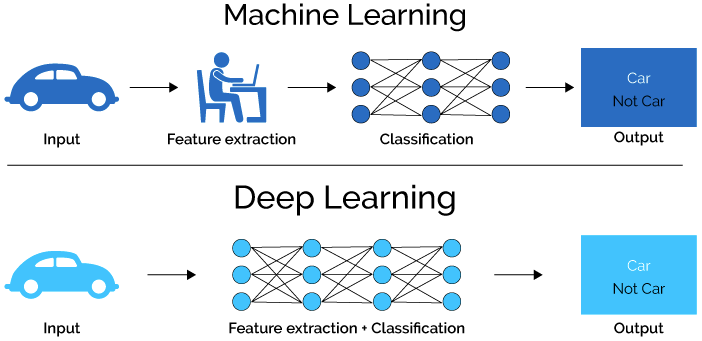

This prediction step (or inference, as often called in ML inference), also leverages on GPU. When running with GPU it is possible to run inference at a rate of up to 150 images per second, thus realizing the full benefits of using  it is one of the advantages of single-shot detectors like YOLOv8. The inference speed decreases with increasing model and image size and with decreasing available GPU memory.

**INPUT:**
- `path_to_tiles_predict`= path to directory where train and validation directories (output from step 3) are stored.
- `path_to_model`= path to model weigths trained in step 4

**OUTPUT:**
The model predictions include:
- images with overlayed boxes and/or
- labels (*.txt in YOLO format) with predicted bounding boxes coordinates.

## Check which model did best
These are the [result](https://www.comet.com/stefp/content-drive-mydrive-nova-course-deep-learning-data-annotated-data-train-23/view/8xy7cYlYGyVkLUwXwUoCIopGG/panels) on an experiment looking at


1.   increasing model size (from nano to XL)
2.   Increasing image size (from 640 to 1000)

From this experiment I would choose the XL model if I have to run on a cloud/server and the nano verion if I was to deploy the model on edge devices.

In [2]:
import os
annotator_ID=17 # change this to your folder ID

path_to_ortho_predict= "/content/drive/MyDrive/NOVA_course_deep_learning/data/orthomosaics/test_data/ortho_hobol_042222_mavic_sun.tif"

path_to_tiles="/content/drive/MyDrive/NOVA_course_deep_learning/data/tiles/10m_"+str(os.path.splitext( os.path.basename(path_to_ortho_predict))[0])
path_to_model="/content/drive/MyDrive/NOVA_course_deep_learning/data/annotated_data/train/17/seedlings_YOLOn_img640/weights/best.pt"



In [3]:
path_to_ortho_predict

'/content/drive/MyDrive/NOVA_course_deep_learning/data/orthomosaics/test_data/ortho_hobol_042222_mavic_sun.tif'

## 5.1 Switch on the GPU (if needed)
For model training we can massively speed up training time when using GPUs. Google Colab offers some free access to GPUs. They also offer some paying options if one wants to use it for larger models.

To switch the GPU on go to Edit > Notebook settings > select "GPU"

## 5.2 Setup YOLOv8 and import other libraries

In [4]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.124 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 24.2/107.7 GB disk)


In [5]:
# other libraries
!pip install geopandas
!pip install rasterio
!pip install folium matplotlib mapclassify
# general python packages
import os, glob, shutil
from pathlib import Path
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
#import warnings
#warnings.filterwarnings("ignore")
#import sys

# geospatial packages
from osgeo import gdal, ogr, osr
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio as rio
path_osgeo_utils= "/usr/local/lib/python3.10/dist-packages/osgeo_utils" # defines path to gdal_retile.py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 32.0 MB/s eta 0:00:00


In [6]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 5.3 Write a function to do the tiling similarly to step 1 BUT with some overlap between the tiles

In [7]:
# Params:
#   - input_ortho_path: path to orthophoto to predict on ("/content/drive/MyDrive/NOVA_course_deep_learning/data/orthomosaics/test_data/krakstad_202304_sun.tif")
#   - footprints_path: path to multipolygon layer of tile footprints ("/content/drive/MyDrive/NOVA_course_deep_learning/data/map_data/drone_acquisitions.geojson")
#   - tile_size_m: tile size in m
#   - buffer_size_m= size of overlap area around each tile in m (used for removing boundary effects)
# input_ortho_path=
# footprints_path=

def tile_orthomosaic(input_ortho_path,footprints_path, tile_size_m, buffer_size_m):
  # Define path to data
  path_data="/content/drive/MyDrive/NOVA_course_deep_learning/data"

  # read drone acquisition footprints
  footprints= gpd.read_file(footprints_path)
  # Get ortho name
  ortho_name=os.path.splitext(os.path.basename(input_ortho_path)) [0]

  # create output dir
  output_tiles_dir=path_data+"/tiles/"+str(tile_size_m)+"m_"+ortho_name
  if not os.path.exists(output_tiles_dir):
    print("Creating output folder..."+ output_tiles_dir)
    os.makedirs(output_tiles_dir)

  # get raster metadata
  # Get pixel resolution (in meters) and tile size in pixels
  src_ds = gdal.Open(input_ortho_path) # reads in the orthomosaic
  _, xres, _, _, _, yres  = src_ds.GetGeoTransform() # get pixel size in meters
  print("Ortho resolution: "+str(round(xres,4))+" m")
  # Get EPSG code
  proj = osr.SpatialReference(wkt=src_ds.GetProjection())
  EPSG_code= proj.GetAttrValue('AUTHORITY',1)
  print("EPSG code: "+str(EPSG_code))
  # get number of bands
  n_bands=src_ds.RasterCount
  print("Number of bands: "+str(n_bands))

  # Compute tile and buffer size in pixels
  tile_size_px= round(tile_size_m/abs(xres)) # calculate the tile size in pixels
  buffer_size_px= round(buffer_size_m/abs(xres)) # calculate the buffer size in pixels
  tileIndex_name=ortho_name+"_tile_index" # define name for output tile index shapefile

  # Run gdal_retile.py using (can take some minutes)
  command_retile = "python "+path_osgeo_utils+"/gdal_retile.py -targetDir " + output_tiles_dir + " " + input_ortho_path+ " -overlap " + str(buffer_size_px) + " -ps "+str(tile_size_px) + " " + str(tile_size_px) + " -of GTiff -tileIndex "+ tileIndex_name + " -tileIndexField ID"
  print(os.popen(command_retile).read()) ################################################################### SWITCH THIS ONE FOR TILING #########################################

  # cleanup tiles
  footprint_ortho= footprints[footprints['filename']==ortho_name]
  footprint_ortho_UU= footprint_ortho.geometry.unary_union
  # Load tiles shapefile
  tiles = gpd.read_file(output_tiles_dir+ "/"+ortho_name+"_tile_index.shp")
  tiles= tiles.to_crs(EPSG_code)

  # Select all tiles that are within the boundary polygon
  tiles_in = tiles[tiles.geometry.within(footprint_ortho_UU)]

  # Select all tiles that are not within the boundary polygon
  tiles_out= tiles.loc[~tiles['ID'].isin(tiles_in['ID']) ]
  print(str(len(tiles_out))+" tiles to be deleted")

  # delete tiles that are not within the footprint
  gtiffs_delete=[output_tiles_dir+ "/"+sub  for sub in tiles_out['ID']]
  for f in gtiffs_delete:
   if os.path.exists(f):
     os.remove(f)





Now use the above written function to tile the orthomosaic we want to predict-on into tiles of same size as the annotated ones (see step 1) but with an overlap of 1 m with neighbouring tiles.

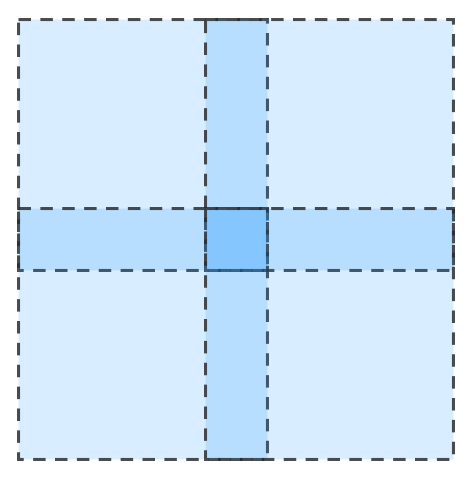

The overalp is needed to avoid having artifacts in the predictions due to non-detection on the edges of the images.

In [8]:
tile_orthomosaic(input_ortho_path=path_to_ortho_predict,
                 footprints_path= "/content/drive/MyDrive/NOVA_course_deep_learning/data/map_data/drone_acquisitions.geojson",
                 tile_size_m=10, # this could be changed
                 buffer_size_m=1) # this could be changed

Ortho resolution: 0.0074 m
EPSG code: 25832
Number of bands: 4
0...10...20...30...40...50...60...70...80...90...100 - done.

261 tiles to be deleted


## 5.4 Predict
The predict function has also several inputs (sources) and arguments that can be modified and a comprehensive list can be found at the [YOLOv8 docs](https://docs.ultralytics.com/modes/predict/) page.

As data soure, we will use the `directory` mode as a source the directory as we will be providing a path to the directory where all the tiles are stored (`path_to_tiles_predict`).

Regarding the arguments, here are some that can be interesting to edit:
- `imgsz`  (default=640) image size to be fed to the model for inference. This should be the same size as it was fed to model training.
- `conf`	(default=0.25)	object confidence threshold for detection. This can be defined based on the the F1 curve in the trained model's folder:
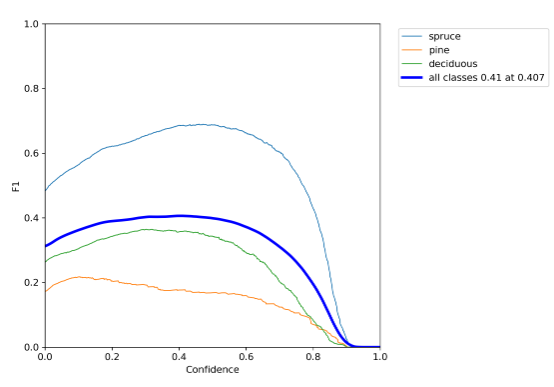

- `iou`	(default=0.7)	intersection over union (IoU) threshold for non-maximum-suppression (NMS). In practice you can decide how much common space two areas have to have to be considered as overlapping and thus removing one of them.



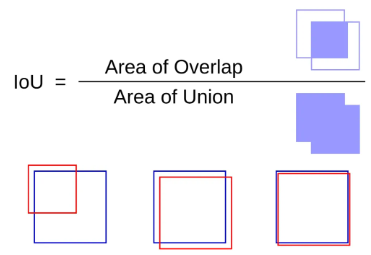

- `save`	(default=False)	save images with results
- `save_txt`	(default=False)	save results as .txt file
- `save_conf`	(default=False)	save results with confidence scores
- `max_det`	(default=300)	maximum number of detections per image
- `visualize`	(default=False)	visualize model features


So let's now build the command to run the inference:

In [9]:
path_to_model

'/content/drive/MyDrive/NOVA_course_deep_learning/data/annotated_data/train/17/seedlings_YOLOn_img640/weights/best.pt'

In [10]:
!yolo predict model=$path_to_model source=$path_to_tiles imgsz=640 conf=0.323 project=$path_to_tiles name=predict_tiles save_txt=True save_conf=True save=True line_width=1

Ultralytics YOLOv8.0.124 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients

image 1/189 /content/drive/MyDrive/NOVA_course_deep_learning/data/tiles/10m_ortho_hobol_042222_mavic_sun/ortho_hobol_042222_mavic_sun_02_12.tif: 640x640 3 trees, 328.9ms
image 2/189 /content/drive/MyDrive/NOVA_course_deep_learning/data/tiles/10m_ortho_hobol_042222_mavic_sun/ortho_hobol_042222_mavic_sun_02_13.tif: 640x640 7 trees, 177.0ms
image 3/189 /content/drive/MyDrive/NOVA_course_deep_learning/data/tiles/10m_ortho_hobol_042222_mavic_sun/ortho_hobol_042222_mavic_sun_02_14.tif: 640x640 9 trees, 188.0ms
image 4/189 /content/drive/MyDrive/NOVA_course_deep_learning/data/tiles/10m_ortho_hobol_042222_mavic_sun/ortho_hobol_042222_mavic_sun_03_11.tif: 640x640 2 trees, 169.5ms
image 5/189 /content/drive/MyDrive/NOVA_course_deep_learning/data/tiles/10m_ortho_hobol_042222_mavic_sun/ortho_hobol_042222_mavic_sun_03_12.tif: 640x640 4 trees, 195.4ms
image 6/189 /conte

## 5.5 Look at the predictions

Just browse to the google drive folder where the images are stored


# Great now let's convert the predictions from image to map space in [postprocessing](https://colab.research.google.com/drive/147jaYNqj2fGRV1-VM6-8eWsVgnODNw6w)